<a href="https://colab.research.google.com/github/candysax/rea_neuro_ns1/blob/main/ns1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Этот набор данных был получен из Национального института диабета, болезней органов пищеварения и почек. Цель набора данных - диагностически предсказать, есть ли у пациента сахарный диабет, на основе определенных диагностических измерений, включенных в набор данных. На выбор этих образцов из более обширной базы данных было наложено несколько ограничений. В частности, все пациенты - женщины в возрасте не менее 21 года, родом из племени пима.

Наборы данных состоят из нескольких медицинских прогностических переменных и одной целевой переменной - результата. Прогностические переменные включают количество беременностей у пациентки, ее индекс массы тела, уровень инсулина, возраст и так далее.

In [95]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

data = pd.read_csv('diabetes.csv')

cols_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

data[cols_to_clean] = data[cols_to_clean].replace(0, np.nan)

# Использование большего количества соседей для заполения пропущенных значений
# Выбираются 7 наиболее похожих по значениям строки на их основе заполняется пропущенная ячейка
# Так же учитывается расстояние (мера схожести объектов). Чем более похожа строка, тем больший вес она имеет.
imputer = KNNImputer(n_neighbors=7, weights='distance')
data_imputed = imputer.fit_transform(data)

data = pd.DataFrame(data_imputed, columns=data.columns)

X = data.drop(columns='Outcome')
y = data['Outcome']

# Генерация новых искуственных примеров.
# Это нужно, чтобы сбалансировать количество больных и здоровых.
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# StandardScaler приводит данные к нормальному распределению со средним 0 и стандартным отклонением 1
# Это даёт больший диапазон значений, чем MinMaxScaler (от 0 до 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# Стратификация (stratify) гарантирует, что соотношение классов в обучающей и тестовой выборках будет таким же, как в исходных данных.
# В старом варианте возникал дисбаланс
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_res,
    test_size=0.2,
    stratify=y_res,
    random_state=42
)

In [97]:
data.head(100)
X_train

array([[ 1.45840335,  0.11678549, -1.13803214, ...,  1.23700265,
         0.50024862,  0.30115112],
       [-1.2134999 ,  0.34455891,  0.94887584, ..., -0.86249373,
        -0.78392566,  2.19905147],
       [ 0.59465591,  1.14737661, -0.92550904, ..., -1.30870687,
        -0.94620105,  1.40704651],
       ...,
       [ 2.40281172,  0.44089703,  0.77847721, ...,  0.90748504,
         0.12542884,  2.11105092],
       [-0.9121406 , -0.55459692, -1.09590767, ..., -1.14509538,
         1.40832291, -1.14496949],
       [ 2.70417103,  1.01892578,  3.50485522, ...,  1.36857195,
        -0.70431887,  0.8790432 ]])

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dense лучше для табличных данных, чем Conv1D
# Conv1D лучше для работы данными где признаки зависят друг друга
# В мед данных такой зависимости нет
def build_model(input_dim):
    model = Sequential()

    # Для борьбы с переобучением мы вырубаем 20% нейронов в каждом шаге
    # Переобучение - это когда модель слишком сильно подстраивается под тренировочные данные и плохо работает на новых.
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    return model

input_dim = X_train.shape[1]

model = build_model(input_dim)

# В наборе данных есть много нулевых или пропущенных значений.
# В данном случае лучше использоввать оптимизатор Adam
# Он уменьшает скорость обучения для признаков, которые часто изменяются, и увеличивает для стабильных.
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    min_delta=0.001
)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6127 - loss: 0.6613 - val_accuracy: 0.6850 - val_loss: 0.5784
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7301 - loss: 0.5593 - val_accuracy: 0.6900 - val_loss: 0.5311
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7184 - loss: 0.5321 - val_accuracy: 0.7200 - val_loss: 0.5207
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7544 - loss: 0.4987 - val_accuracy: 0.7200 - val_loss: 0.5177
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7312 - loss: 0.5173 - val_accuracy: 0.7250 - val_loss: 0.5141
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7637 - loss: 0.4741 - val_accuracy: 0.7400 - val_loss: 0.5066
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7542 - loss: 0.5068 - val_accuracy: 0.7500 - val_loss: 0.5036
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7427 - loss: 0.5020 - val_accuracy: 0.7500 - val_loss: 0.

In [99]:
from sklearn.metrics import precision_score, recall_score, f1_score
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')
print(f'Loss: {loss:.2f}')

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.55).astype("int32")

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7801 - loss: 0.4782
Accuracy: 0.80
Loss: 0.45
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Precision: 0.79
Recall: 0.80
F1 Score: 0.80


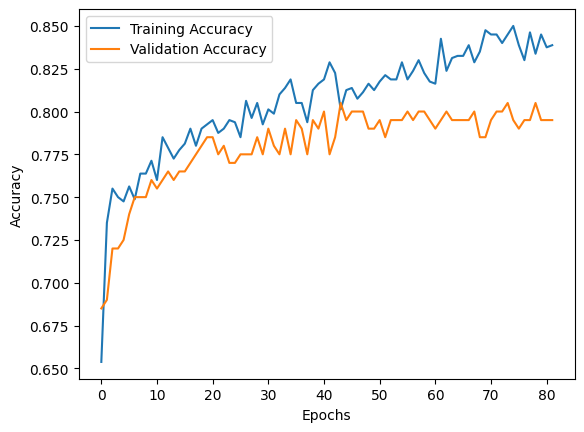

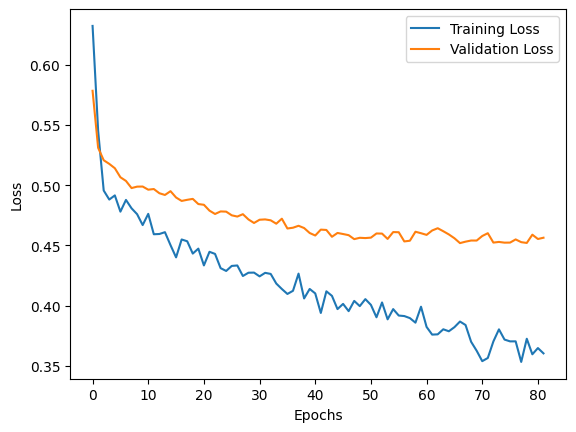

In [100]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()